(c) 2021, Franz Ludwig Kostelezky, IMTEK chair of simulation, \<info@kostelezky.com\>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from datetime import datetime

In [2]:
# import physiobank ecg data
data_physionet = pd.read_csv('./ECG_data/physionet/ecg_id_01_1.csv', sep=",", header=2)
data_physionet.columns = ['time', 'ECG I', 'ECG I filtered']

In [3]:
t_max = 20 # s
len_series = len(data_physionet['ECG I'])
sample_frequency = len_series / t_max
t = np.linspace(0, t_max, len_series)

<IPython.core.display.Javascript object>


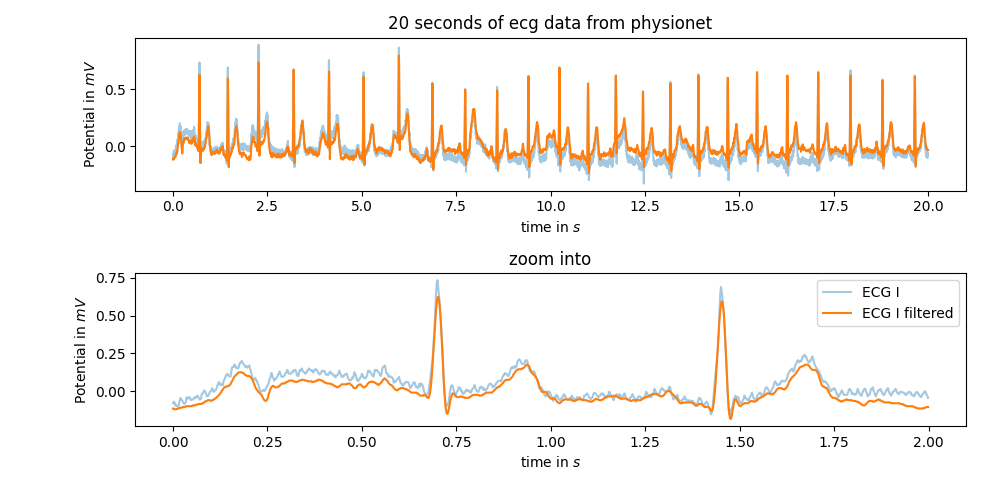

In [4]:
%matplotlib notebook
plt.subplot(2, 1, 1)
plt.title('20 seconds of ecg data from physionet')
plt.plot(t, data_physionet['ECG I'], alpha=.4, label='ECG I')
plt.plot(t, data_physionet['ECG I filtered'], label='ECG I filtered')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.subplot(2, 1, 2)
plt.title('zoom into')
plt.plot(t[:1000], data_physionet['ECG I'][:1000], alpha=.4, label='ECG I')
plt.plot(t[:1000], data_physionet['ECG I filtered'][:1000], label='ECG I filtered')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# original time series
series_np = np.array(data_physionet['ECG I filtered'])
print('validation before cut:', series_np[0] == series_np[-1])

# these are the points where the periodical condition is true
# we cut at the last possible point
o = np.where(series_np == series_np[0])
series_np_cut = series_np[0:o[0][10] + 1]

# validating cut
print('validation after cut:', series_np_cut[0] == series_np_cut[0])

validation before cut: False
validation after cut: True


# Fit to another nonlinear oscillator
Changing the system to have only odd exponents on $x$.

$$
\dot{x} = v
\\
\dot{v} = -\omega_0^2x + q_3x^3 + q_5x^5 + q_7x^7 + q_9x^9 + ...
$$

Which needs a new fit:

$$
\begin{pmatrix}
\sum_i^n x^6 & \sum_i^n x^8 & \sum_i^n x^{10} & \sum_i^n x^{12} \\
\sum_i^n x^8 & \sum_i^n x^{10} & \sum_i^n x^{12} & \sum_i^n x^{14} \\
\sum_i^n x^{10} & \sum_i^n x^{12} & \sum_i^n x^{14} & \sum_i^n x^{16} \\
\sum_i^n x^{12} & \sum_i^n x^{14} & \sum_i^n x^{16} & \sum_i^n x^{18} \\
\end{pmatrix}
\cdot
\begin{pmatrix}
q_3 \\
q_5 \\
q_7 \\
q_9 \\
\end{pmatrix}
=
\begin{pmatrix}
\sum_i^n z_i x^3 + \omega_0^2x^4 \\
\sum_i^n z_i x^5 + \omega_0^2x^6 \\
\sum_i^n z_i x^7 + \omega_0^2x^8 \\
\sum_i^n z_i x^9 + \omega_0^2x^{10} \\
\end{pmatrix}
$$

In [76]:
def five_point_derivate_periodic(series):
    ''' Returns the 1D second order upwind derivate of a one dimensional
    time series using reflecting boundary conditions.
    '''

    series = np.array(series)
    dx = 1
    d_pos = (- 3 * series \
             + 4 * np.roll(series, shift=-1, axis=0) \
             - np.roll(series, shift=-2, axis=0)
            ) / (2 * dx)
    d_neg = (+ 3 * series \
             - 4 * np.roll(series, shift=1, axis=0) \
             + np.roll(series, shift=2, axis=0)
            ) / (2 * dx)
    derivate = d_pos
    derivate[-3::] = d_neg[-3::]

    return derivate

In [77]:
def solve_eqs_for_q_odd(x, v, z, omega):
    '''
    '''
    omega_squared = omega ** 2
    
    a = [[np.sum(x ** 6), np.sum(x ** 8), np.sum(x ** 10), np.sum(x ** 12)],
         [np.sum(x ** 8), np.sum(x ** 10), np.sum(x ** 12), np.sum(x ** 14)],
         [np.sum(x ** 10), np.sum(x ** 12), np.sum(x ** 14), np.sum(x ** 16)],
         [np.sum(x ** 12), np.sum(x ** 14), np.sum(x ** 16), np.sum(x ** 18)],]
    b = [[np.sum(z * x ** 3 + omega_squared * x ** 4)],
         [np.sum(z * x ** 5 + omega_squared * x ** 6)],
         [np.sum(z * x ** 7 + omega_squared * x ** 8)],
         [np.sum(z * x ** 7 + omega_squared * x ** 10)]]
    
    return np.linalg.solve(a, b)

In [82]:
def convert_odd_fit_coefficients_to_fit_function_static_grade(q, omega):
    assert(len(q) == 4)
    
    omega_squared = omega ** 2
    
    def func(x, v):
        res = - omega_squared * x + q[0] * x ** 3 + q[1] * x ** 5 + q[2] * x ** 7 + q[3] * x ** 9
        return res

    return func

In [116]:
omega = 1.0999999999999999
omega_sqared = omega ** 2
index = 'ECG I filtred cut'
series = series_np_cut

In [117]:
p_1_ = solve_eqs_for_q_odd(series, \
                           five_point_derivate_periodic(series), \
                           five_point_derivate_periodic(series),
                           omega)
p_2_ = solve_eqs_for_q_odd(series, \
                           five_point_derivate_periodic(series), \
                           five_point_derivate_periodic(five_point_derivate_periodic(series)),
                           omega)

In [118]:
p_1 = convert_odd_fit_coefficients_to_fit_function_static_grade(p_1_, omega)
p_2 = convert_odd_fit_coefficients_to_fit_function_static_grade(p_2_, omega)

<IPython.core.display.Javascript object>


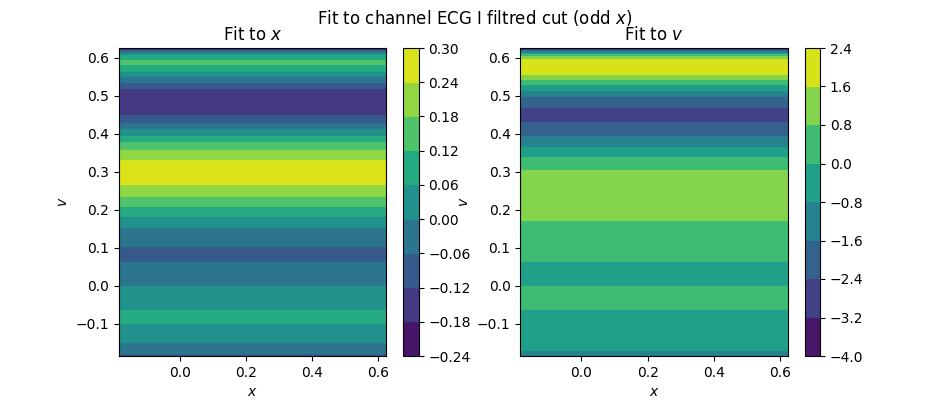

In [119]:
%matplotlib notebook

y = np.linspace(min(series), max(series), 100)
ydot = y

fig = plt.figure(figsize=(9.5, 4))
fig.suptitle('Fit to channel %s (odd $x$)' % (index))

ax_1 = fig.add_subplot(1, 2, 1)
r_1 = [[np.sum(p_1(el, sel)) for sel in ydot] for el in y]
c = ax_1.contourf(y, ydot, r_1)
fig.colorbar(c)
ax_1.set_xlabel('$x$')
ax_1.set_ylabel('$v$')
ax_1.set_title('Fit to $x$')

ax_2 = fig.add_subplot(1, 2, 2)
r_2 = [[np.sum(p_2(el, sel)) for sel in ydot] for el in y]
c = ax_2.contourf(y, ydot, r_2)
fig.colorbar(c)
ax_2.set_xlabel('$x$')
ax_2.set_ylabel('$v$')
ax_2.set_title('Fit to $v$')

plt.show()

# Creating and solving ODE

In [120]:
def func_omega_periodic_kubo(t, x, _, fit_to_ydot):
    ''' ECG common channel system
    '''
    y = [0, 0]

    y[0] = x[1]
    y[1] = fit_to_ydot(x[0], x[1])[0]
    return y

In [121]:
T = len(series)
#T = 100 # shorter computation time

ivp = [0, 0]
index_start = 0
ivp[0] += series[index_start]
ivp[1] += five_point_derivate_periodic(series)[index_start]

sol = solve_ivp(func_omega_periodic_kubo, [0, T], [ivp[0], ivp[1]], dense_output=True, args=[p_1, p_2])

t = np.linspace(0, T, T*2)
y, ydot = sol.sol(t)

res = (t, y, ydot)

<IPython.core.display.Javascript object>


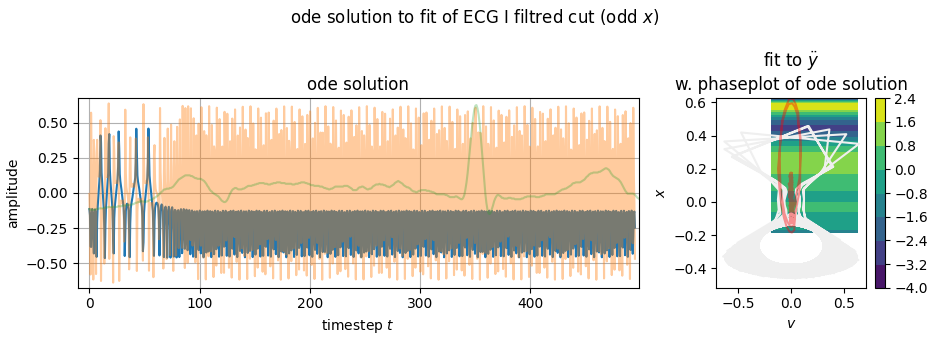

In [129]:
%matplotlib notebook

fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[3, 1]}, figsize=(9.5, 3.5))

max_index = T
a0.plot(res[0][:max_index]+index_start, res[1][:max_index], label='$y$')
a0.plot(res[0][:max_index]+index_start, res[2][:max_index], label='$\dot{y}$', alpha=0.4)
a0.plot(series[:index_start+max_index], label='original $y$', alpha=0.3)
a0.set_xlabel('timestep $t$')
a0.set_ylabel('amplitude')
a0.grid()
#a0.legend()
a0.set_title('ode solution')

y_ = np.linspace(min(series), max(series), 100)
ydot_ = y_
#r_2 = [[np.sum(p_2(el, sel)) for sel in ydot_] for el in y_]
c = a1.contourf(y_, ydot_, r_2)
a1.plot(res[2][:max_index], res[1][:max_index], c='#efefef')
a1.scatter(res[2][0], res[1][0], s=25, c='red', marker='x')
a1.plot(five_point_derivate_periodic(series)[:index_start+max_index], series[:index_start+max_index], c='red', alpha=.4)
fig.colorbar(c)
a1.set_title('fit to $\ddot{y}$\nw. phaseplot of ode solution')
a1.set_xlabel('$v$')
a1.set_ylabel('$x$')

fig.suptitle('ode solution to fit of %s (odd $x$)' % (index))

plt.tight_layout()
plt.show()

plt.savefig('./.tmp/image.png')

<IPython.core.display.Javascript object>


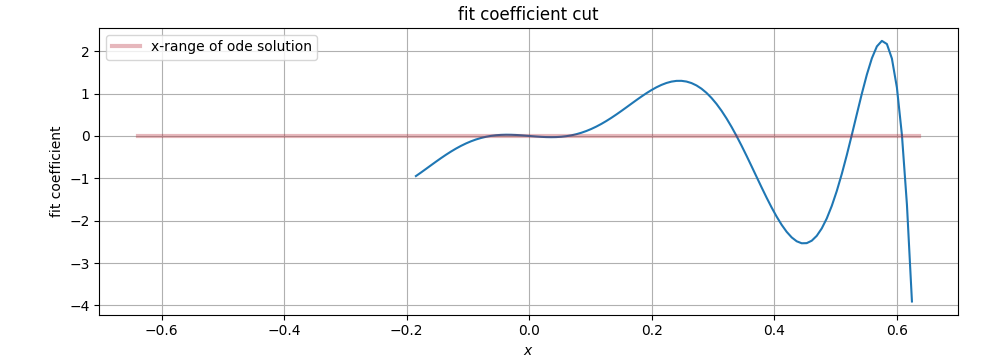

In [131]:
%matplotlib notebook
r_2 = np.asarray([np.asarray(el) for el in r_2])
plt.plot(y_, r_2[::, r_2.shape[-1]//2])
plt.plot([min(res[2]), max(res[2])], [0., 0.], c='#af1221', linewidth=3, label='x-range of ode solution', alpha=.3)
plt.xlabel('$x$')
plt.ylabel('fit coefficient')
plt.legend()
plt.grid()
plt.title('fit coefficient cut')
plt.tight_layout()
plt.show()